## Import all of the packages

In [1]:
from RHaP import import_image
from RHaP import cropping_functions as crop
from matplotlib import pyplot as plt
from RHaP import plot_functions as plt_f
from RHaP import Radial_Hydride_Fraction as RHF
from RHaP import branching as branch
from RHaP import crack_path as cp
from RHaP import image_processing
from skan import draw


/Users/miamaric/opt/anaconda3/lib/python3.8/site-packages/skan/csr.py:21: NumbaDeprecationWarning: The 'numba.jitclass' decorator has moved to 'numba.experimental.jitclass' to better reflect the experimental nature of the functionality. Please update your imports to accommodate this change and see https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#change-of-jitclass-location for the time frame.
  @numba.jitclass(csr_spec)


## Importing Image

(-0.5, 2047.5, 1535.5, -0.5)

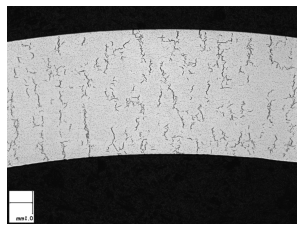

In [2]:
original_image = import_image.image(image_path ='example.bmp', transpose = True)

plt.imshow(original_image, cmap='gray')
plt.axis('off')

## Cropping Image

The first crop function `cropImage` is a rectangular crop this should be performed if you need to remove any addded scale bars or have a specific rectangular region you want to look at. 

The second crop function is `cropping_tube` this should be used if the micrograph is curved 

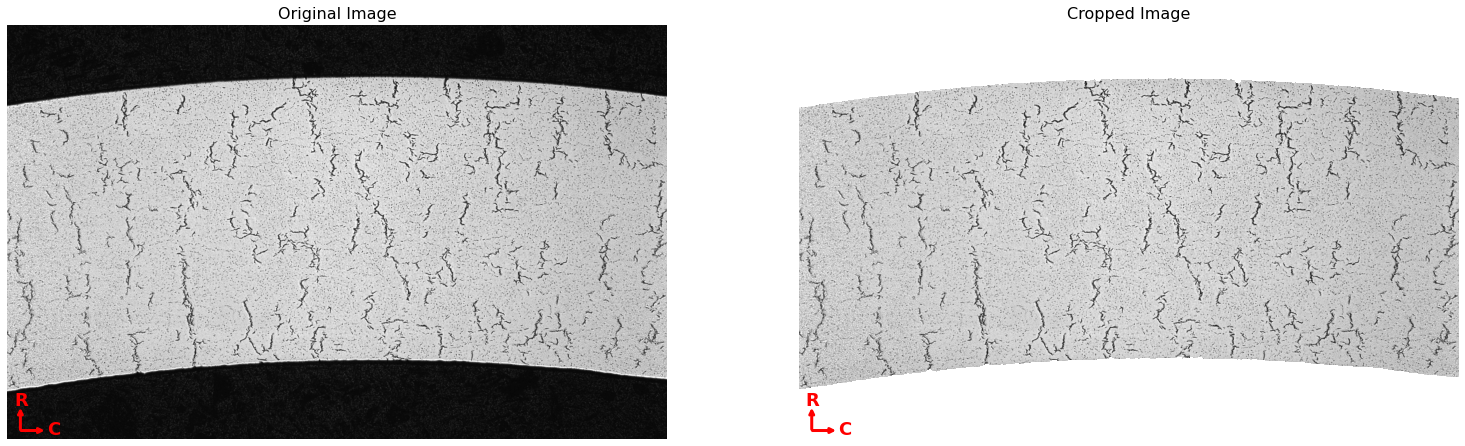

In [3]:
cropped_image = crop.cropImage(original_image, crop_bottom=250,crop_top=0, crop_left=0, crop_right=0)
cropped_image,crop_threshold = crop.cropping_tube(cropped_image,crop_param = 0.1, size_param = 500, dilation_param =5)

plt_f.plot_comparison(original_image, 'Original Image', cropped_image,'Cropped Image')



## Image Processing

Here the main aim is to accurately threshold an image to do this the grain contast is minimised through the application of a gaussian blurr in the `minimize_grain_contrast` function. After this, the images is thresholded using the `simple_threshold` function. Note it is important not too over threshold the image, guidance of a value to threshold can be attained by plotting histograms of the grain contrast.

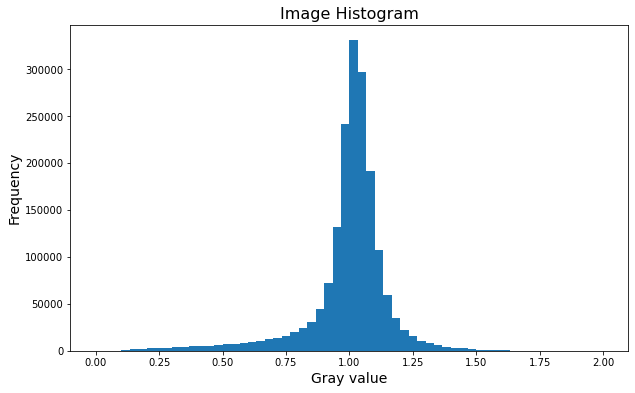

In [5]:
removed_grains =image_processing.minimize_grain_contrast(cropped_image, sigma=4)

#Plot the histogram for removed grains so that we can see where we should threshold --> is it possible to draw a red line where we reccomend the threshold???
histogram = plt_f.plot_hist(removed_grains)


/Users/miamaric/Desktop/Rhap/RHaP/image_processing.py:64: RuntimeWarning: invalid value encountered in less
  thres = arr < threshold


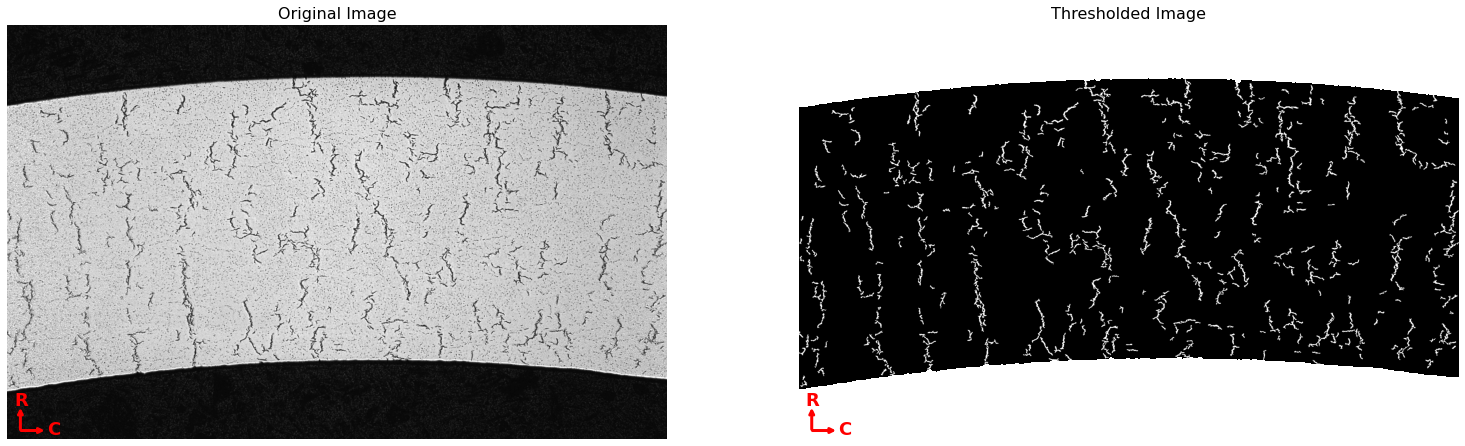

In [6]:
thres = image_processing.simple_threshold(removed_grains,crop_threshold,threshold = 0.85, small_grains = 50)

# we now want to plot the thresholded image and compare it to the original image: 
plt_f.plot_comparison(original_image, 'Original Image', thres,'Thresholded Image')


## Radial Hydride Fraction Calculation

The first step is to perform the hough line transform `hough_rad` there are a few input parameters that should be considered: 
`num_peaks`: this one should change dependent on the type of micrograph, if your hydrides are straight and not very interconnected a small value of around 2 is good, if in one box, there are many branches that need to be picked up, this value should be increased accordingly.
`min_dist,min_angle and val` are pre-set and seem to work for most cases
        

/Users/miamaric/Desktop/Rhap/RHaP/Radial_Hydride_Fraction.py:58: RuntimeWarning: invalid value encountered in greater
  label, num_features = ndimage.label(arr > 0.1)


Number of detected angles: 1031


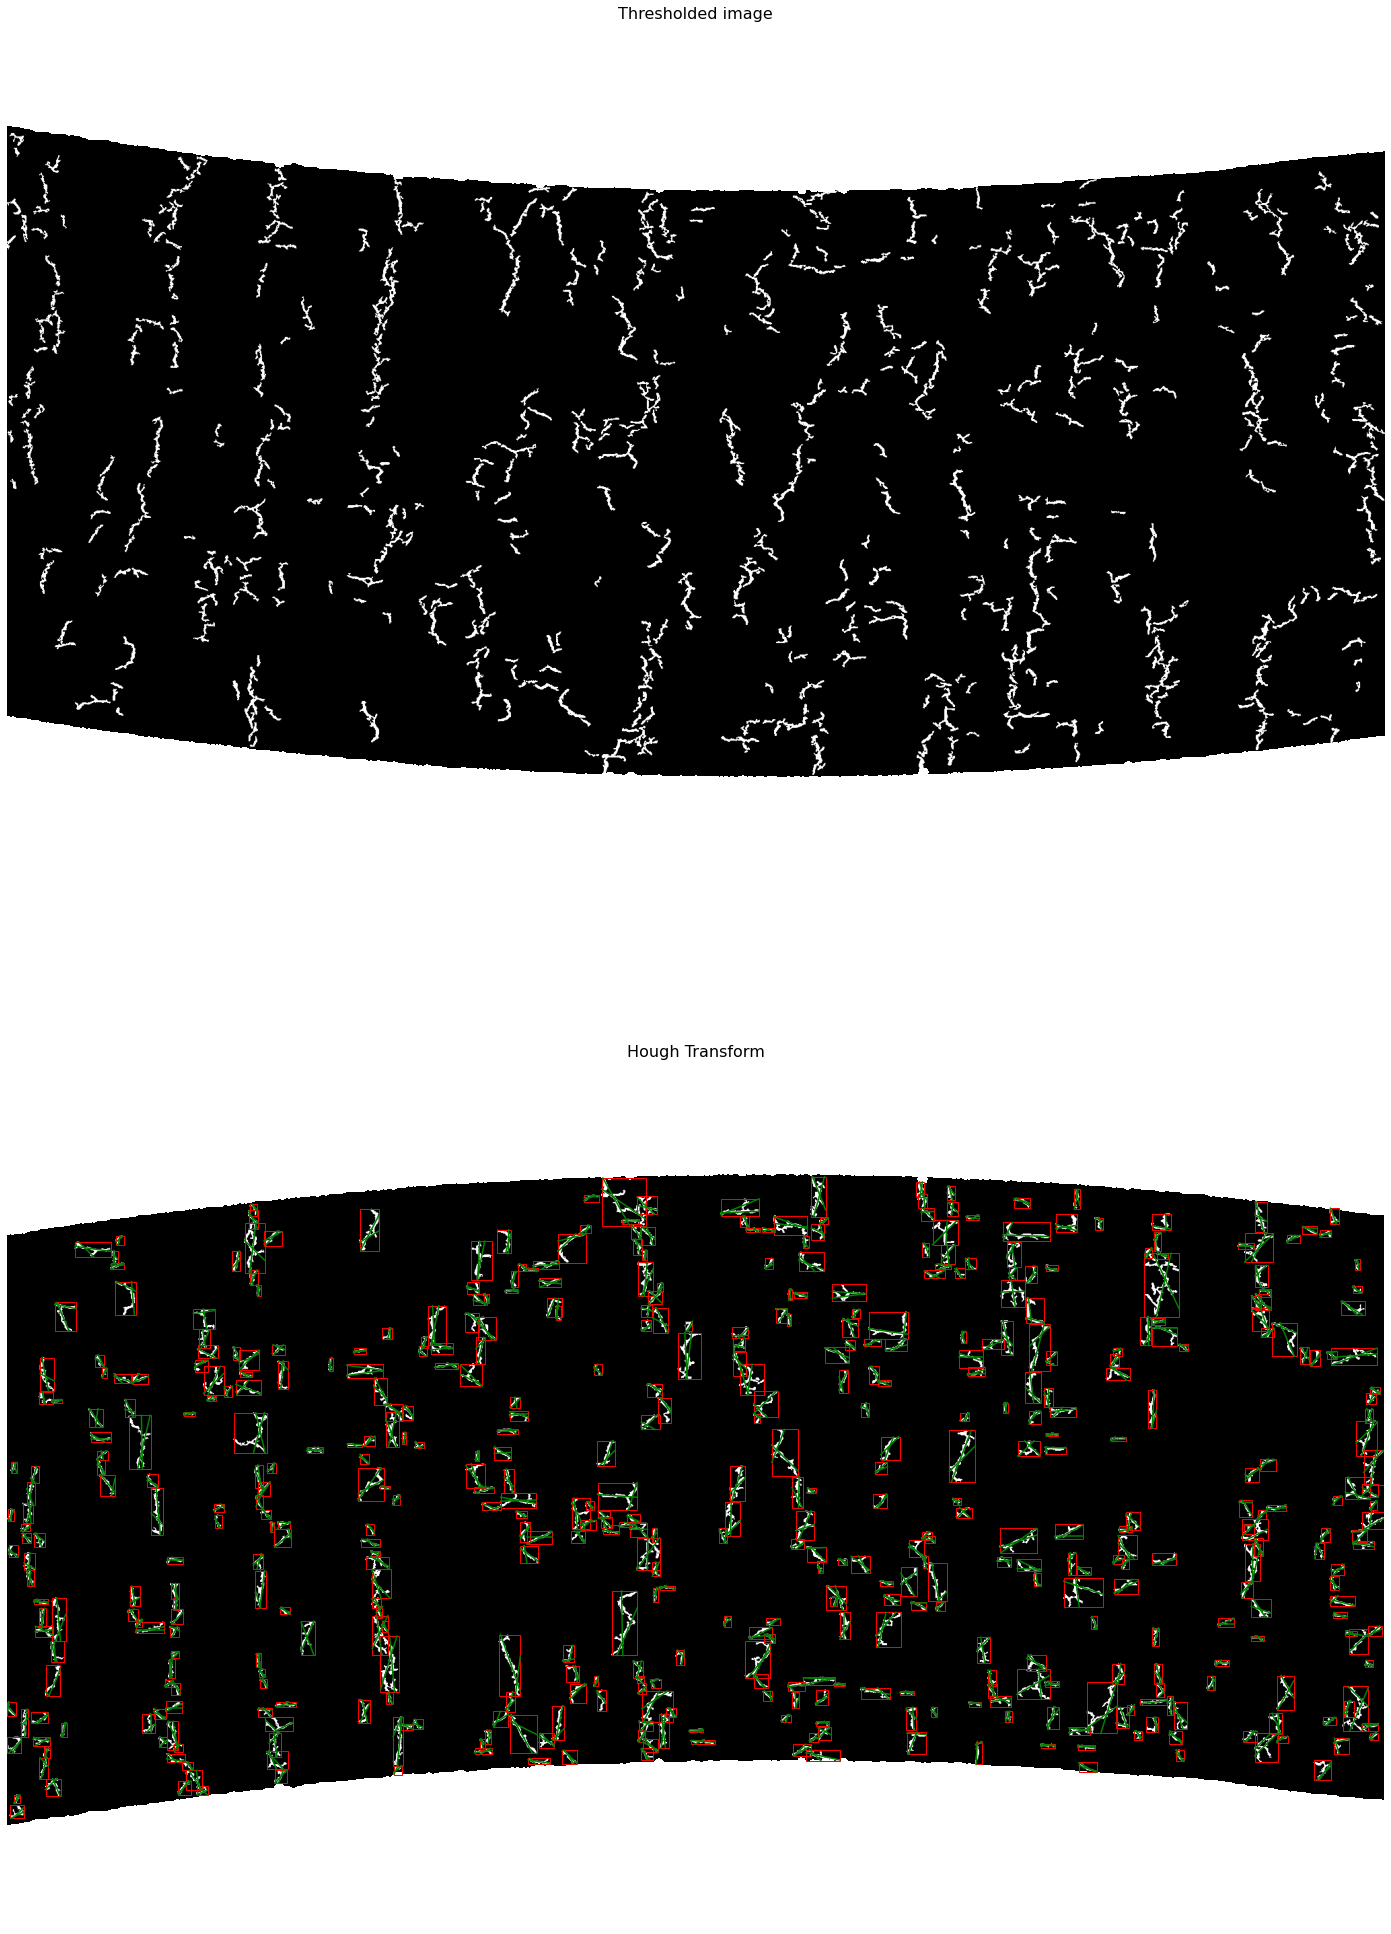

In [7]:
angle_list,len_list = RHF.hough_rad(thres,num_peaks=2)

In [8]:
#Non weighted radial hydride fraction

radial, circumferential = RHF.RHF_no_weighting_factor(angle_list,len_list)

print('The non-weighted RHF =',radial)
print('The non-weighted CHF =', circumferential)


The non-weighted RHF = 0.4733370937649152
The non-weighted CHF = 0.9999610052202925


In [9]:
#Weighted Radial Hydride Fraction 

RHF = RHF.weighted_RHF_calculation(angle_list,len_list)

print('The weighted RHF =',RHF)

The weighted RHF = 0.5245802056666812


## Branch Length Fraction

##### Here we want to determine the extent of branching within the microstrucutre, this is done in two ways: 
    - In image form where the branches are coloured differently to the main hydride
    - BLF the length fraction of branches with respect to the toatal length of all hydrides in the microstrucutre

In [10]:
skel,is_main,BLF = branch.branch_classification(thres);



(-0.5, 2047.5, 1285.5, -0.5)

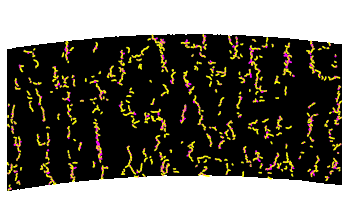

In [11]:
#I dk how to make this bigger, better quality and how to add a legend? 

branched_image = draw.overlay_skeleton_2d_class(
    skel,
    skeleton_color_source=lambda s: is_main,
    skeleton_colormap='spring',

     )

plt.axis('off')


## Crack Path

#####  Here we want to determine potential crack paths through the microstrucutre, we input the thresholded image 

In [12]:
edist, path_list, cost_list = cp.det_crack_path(thres,crop_threshold,num_runs=5)

Run #0	Cost = 1985.91
Run #1	Cost = 1999.27
Run #2	Cost = 2592.75
Run #3	Cost = 2708.05
Run #4	Cost = 2775.78


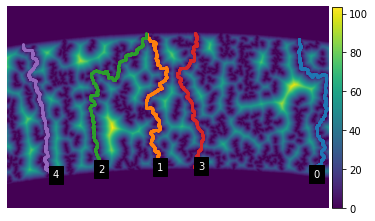

In [13]:
list_costs = []
for n, (p, c) in enumerate(zip(path_list, cost_list)):
    im = plt.imshow(edist)
    if n==0:
        plt.colorbar(im,fraction=0.03, pad=0.01)
    plt.scatter(p[:,1], p[:,0], s=3)
    plt.text(p[-1][1], p[-1][0], s=str(n), c='w', bbox=dict(facecolor='black', edgecolor='black'))
    plt.axis('off')
    print('Run #{0}\tCost = {1:.2f}'.format(n,c))
    list_costs.append(c)

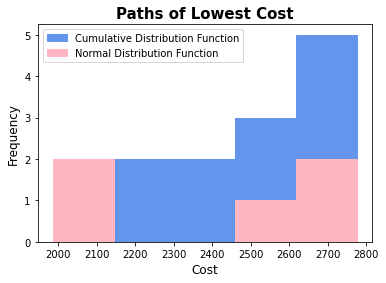

In [14]:
#Histograms for plotting the costs of each path
plt.hist(list_costs, bins=5, cumulative = True, color = "cornflowerblue", ec="cornflowerblue", label = "Cumulative Distribution Function")
plt.hist(list_costs, bins=5, color = "lightpink", ec="lightpink", label = "Normal Distribution Function")
plt.legend()
plt.xlabel('Cost', fontsize="12")
plt.ylabel('Frequency',fontsize="12")
plt.title('Paths of Lowest Cost', fontweight="bold", fontsize="15")
plt.show()